# Convergence of Fitzhugh-Nagumo model

In [1]:
import solver

# Define Fitzhugh-Nagumo model
def fitzhugh_nagumo(x, y):
    alpha = 0.1
    gamma = 0.5
    epsilon = 0.01
    eq1 = (y[0] * (1 - y[0]) * (y[0] - alpha) - y[1] + 0.026) / epsilon
    eq2 = y[0] - gamma * y[1]

    return [eq1, eq2]

# Define initialisation value for numerical method
x_min = 0
x_max = 1
initial_value = [0.01, 0.01]

In [2]:
# Create reference solution
ref_stepsize = 1e-7
mesh_pt = (x_max - x_min) / ref_stepsize

problem = solver.OneStepMethods(
    fitzhugh_nagumo, x_min, x_max, initial_value, mesh_pt)

# Solve with Euler's explicit method
ref_mesh, ref_soln = problem.Euler_explicit()

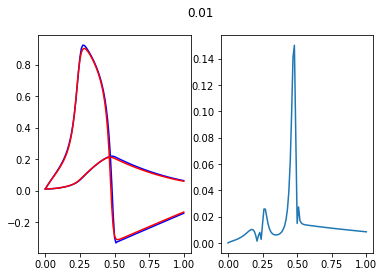

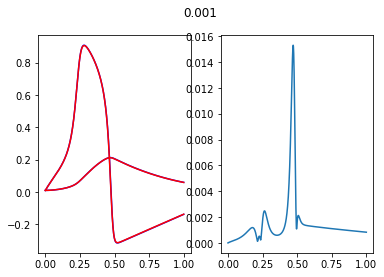

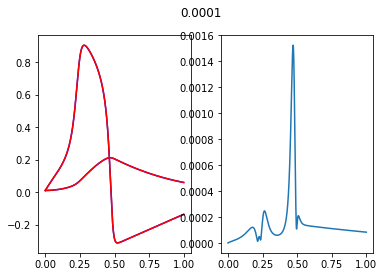

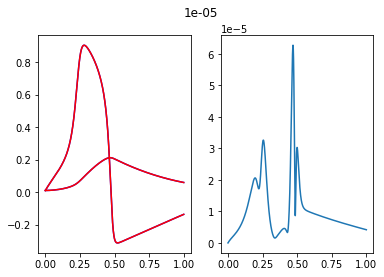

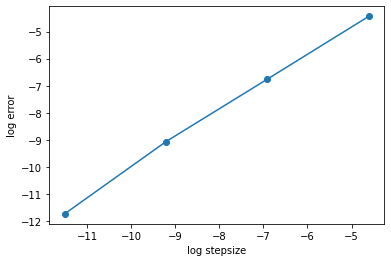

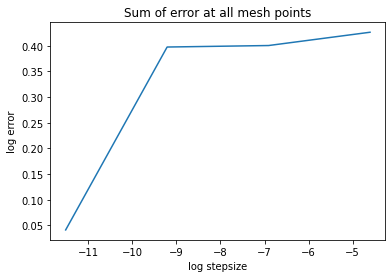

In [3]:
stepsize_range = [1e-2, 1e-3, 1e-4, 1e-5]
meshpt_range = [(x_max - x_min) / step for step in stepsize_range]
mesh_list = []
soln_list = []
for mesh_points in meshpt_range:
    problem = solver.OneStepMethods(
        fitzhugh_nagumo, x_min, x_max, initial_value, mesh_points)

    # Solve with Euler's explicit method
    mesh, soln = problem.Euler_explicit()
    mesh_list.append(mesh)
    soln_list.append(soln)

import numpy as np

exact_soln_list = []
error_list = []
count = 0
for (mesh,soln) in zip(mesh_list,soln_list):
    mesh_point_diff = stepsize_range[count] / ref_stepsize
    exact_soln = []
    error = []
    for i in range(len(mesh)):
        ref_value = ref_soln[int(i * mesh_point_diff)]
        exact_soln.append(ref_value)
        
        err_value = np.linalg.norm(np.array(ref_value) - np.array(soln[i]))
        error.append(err_value)
        
    exact_soln_list.append(exact_soln)
    error_list.append(error)
    count += 1
    
    
import matplotlib.pyplot as plt

for i in range(len(mesh_list)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(str(stepsize_range[i]))
    ax1.plot(mesh_list[i], soln_list[i], 'b')
    ax1.plot(mesh_list[i], exact_soln_list[i], 'r')
    ax2.plot(mesh_list[i], error_list[i])
    plt.show()

sum_error_stepsize = []
error_stepsize = []
for i in range(len(stepsize_range)):
    sum_error_stepsize.append(np.sum(np.array(error_list[i])))
    error_stepsize.append(error_list[i][int(0.7/stepsize_range[i])])

plt.figure()
plt.plot(np.log(np.array(stepsize_range)), np.log(np.array(error_stepsize)))
plt.scatter(np.log(np.array(stepsize_range)), np.log(np.array(error_stepsize)))
plt.xlabel('log stepsize')
plt.ylabel('log error')
plt.show()
    
plt.figure()
plt.plot(np.log(np.array(stepsize_range)), np.log(np.array(sum_error_stepsize)))
plt.ylabel('log error')
plt.xlabel('log stepsize')
plt.title('Sum of error at all mesh points')
plt.show()

# Adaptive method

In [4]:
# Create reference solution
ref_tolerance = 1e-8

problem = solver.AdaptiveMethod(
    fitzhugh_nagumo, x_min, x_max, initial_value, initial_mesh=0.1)

# Solve with adaptive method
ref_mesh, ref_soln = problem.ode23(abs_tol=ref_tolerance, rel_tol=1e-15)

In [5]:
from tqdm.notebook import tqdm
tolerance_range = [1e-2, 1e-3, 1e-4, 1e-5]
mesh_list = []
soln_list = []
for tolerance in tqdm(tolerance_range):
    problem = solver.AdaptiveMethod(
        fitzhugh_nagumo, x_min, x_max, initial_value, initial_mesh=0.1)

    # Solve with adaptive ode23 method
    mesh, soln = problem.ode23(abs_tol=tolerance, rel_tol=1e-15)
    mesh_list.append(mesh)
    soln_list.append(soln)

  0%|          | 0/4 [00:00<?, ?it/s]

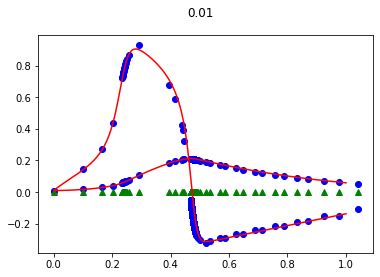

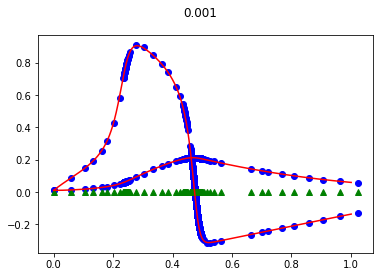

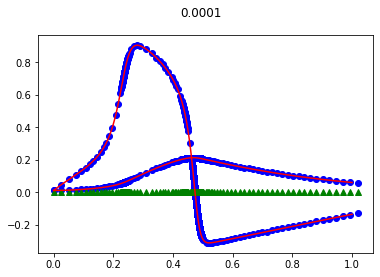

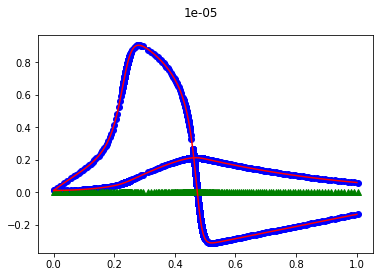

In [6]:
for i in range(len(mesh_list)):
    fig, (ax1) = plt.subplots(1, 1)
    fig.suptitle(str(stepsize_range[i]))
    ax1.plot(mesh_list[i], soln_list[i], 'bo')
    ax1.plot(mesh_list[i], [0] * len(mesh_list[i]), 'g^')
    ax1.plot(ref_mesh, ref_soln, 'r')
    plt.show()

In [7]:
chosen_entries = []
for i in tqdm(range(len(mesh_list[0]))):
    min1 = abs(min(mesh_list[1], key=lambda x:abs(x-mesh_list[0][i])) - mesh_list[0][i])
    min2 = abs(min(mesh_list[2], key=lambda x:abs(x-mesh_list[0][i])) - mesh_list[0][i])
    min3 = abs(min(mesh_list[3], key=lambda x:abs(x-mesh_list[0][i])) - mesh_list[0][i])
    min4 = abs(min(ref_mesh, key=lambda x:abs(x-mesh_list[0][i])) - mesh_list[0][i])
    if max(min1, min2, min3, min4) < 1e-6:
        chosen_entries.append(i)
chosen_entries = chosen_entries[1:]

  0%|          | 0/2685 [00:00<?, ?it/s]

2480


In [8]:
chosen_mesh_points = []
for a in chosen_entries:
    chosen_point = mesh_list[0][a]
    min1_pos = np.argmin(abs(np.array(mesh_list[1]) - chosen_point))
    min2_pos = np.argmin(abs(np.array(mesh_list[2]) - chosen_point))
    min3_pos = np.argmin(abs(np.array(mesh_list[3]) - chosen_point))
    min4_pos = np.argmin(abs(np.array(ref_mesh) - chosen_point))
    chosen_mesh_points.append([a, min1_pos, min2_pos, min3_pos, min4_pos])

2480
1859


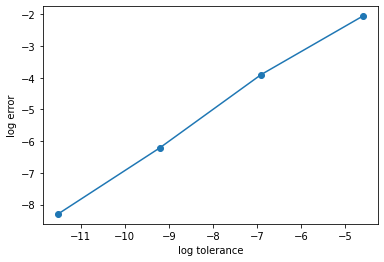

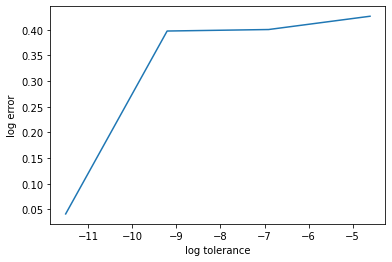

In [9]:
error_list = []
print(len(chosen_mesh_points))
for i in range(len(tolerance_range)):
    error = []
    for points in chosen_mesh_points:
        ref_value = ref_soln[points[4]]

        err_value = np.linalg.norm([ref_value[k] - soln_list[i][points[i]][k] for k in range(2)])
        error.append(err_value)
        
    error_list.append(error)

fixed_point = round(len(error_list[0])*3/4-1)
error_tolerance = []
for i in range(len(tolerance_range)):
    error_tolerance.append(error_list[i][fixed_point])
    
plt.figure()
plt.plot(np.log(np.array(tolerance_range)), np.log(np.array(error_tolerance)))
plt.scatter(np.log(np.array(tolerance_range)), np.log(np.array(error_tolerance)))
plt.xlabel('log tolerance')
plt.ylabel('log error')
plt.show()
    
sum_error_tolerance = []
for i in range(len(tolerance_range)):
    sum_error_tolerance.append(np.sum(np.array(error_list[i])))

plt.figure()
plt.plot(np.log(np.array(tolerance_range)), np.log(np.array(sum_error_stepsize)))
plt.ylabel('log error')
plt.xlabel('log tolerance')
plt.show()